<a href="https://colab.research.google.com/github/mengyush/data-science/blob/main/IEEE_CIS_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

more about the data: https://www.kaggle.com/c/ieee-fraud-detection/data

In [1]:
import pandas as pd
import numpy as np
import random
import sklearn
from collections import Counter
from sklearn.model_selection import train_test_split

# To ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#df = pd.read_csv('/content/sample_data/fraud_data.csv')
df = pd.read_csv("https://raw.githubusercontent.com/dphi-official/Imbalanced_classes/master/fraud_data.csv")
df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2994681,0,242834,25.000,H,9803,583.0,150.0,visa,226.0,...,firefox 56.0,24.0,1920x1080,match_status:2,T,F,T,T,desktop,rv:56.0
1,3557242,0,15123000,117.000,W,7919,194.0,150.0,mastercard,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3327470,0,8378575,73.773,C,12778,500.0,185.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3118781,0,2607840,400.000,R,12316,548.0,150.0,visa,195.0,...,mobile safari generic,32.0,1136x640,match_status:2,T,F,T,F,mobile,iOS Device
4,3459772,0,12226544,31.950,W,9002,453.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*   Target Variable – isFraud

take a look at how many fraud transactions and normal transactions are there:


In [3]:
df.isFraud.value_counts()

0    57049
1     2005
Name: isFraud, dtype: int64

## Pre-Processing

Train / Test Data Split

In [4]:
# set x and y variables
y = df['isFraud']
x = df.loc[:, df.columns != 'isFraud']
# Split randomly into 70% train data and 30% test data
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.3, random_state = 123)

Step 1. Check for missingness in variables

In [5]:
xTrain.isnull().sum()

TransactionID         0
TransactionDT         0
TransactionAmt        0
ProductCD             0
card1                 0
                  ...  
id_36             31403
id_37             31403
id_38             31403
DeviceType        31419
DeviceInfo        33011
Length: 433, dtype: int64

Eliminate variables with more than 20% missing data

In [ ]:
xTrain_before_filling = xTrain
xTrain = xTrain[xTrain.columns[xTrain.isnull().mean() < 0.2]]

check missing again

In [ ]:
missing_cols = xTrain.columns[xTrain.isnull().mean() > 0]
print(missing_cols)

Index(['card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2',
       'P_emaildomain', 'D1', 'D10',
       ...
       'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320',
       'V321'],
      dtype='object', length=162)


In [ ]:
xTrain['card5'].isnull().mean()

0.007499334736434671

Step 1a. Filling missing Numeric Variables with mean of the variable

In [ ]:
xTrain_single = xTrain
cols = xTrain_single.columns
# columns of numeric variables
num_cols = xTrain_single.select_dtypes(include=np.number).columns
xTrain_single.loc[:,num_cols] = xTrain_single.loc[:,num_cols].fillna(xTrain_single.loc[:,num_cols].mean())

Step 1b. Filing missing Categorical Variables with mode of the variable

In [ ]:
cat_cols = list(set(cols) - set(num_cols))
xTrain_single.loc[:,cat_cols] = xTrain_single.loc[:,cat_cols].fillna(xTrain.loc[:,cat_cols].mode().iloc[0])
train_cols = xTrain_single.columns
print(cat_cols)
print(xTrain_single.loc[:,cat_cols].mode().iloc[0])

['ProductCD', 'card6', 'P_emaildomain', 'card4']
ProductCD                W
card6                debit
P_emaildomain    gmail.com
card4                 visa
Name: 0, dtype: object


Check if no missing data now

In [ ]:
xTrain_single.columns[xTrain_single.isnull().mean() > 0]

Index([], dtype='object')

Comparing variable before and after fillna for variable 'Card5' 

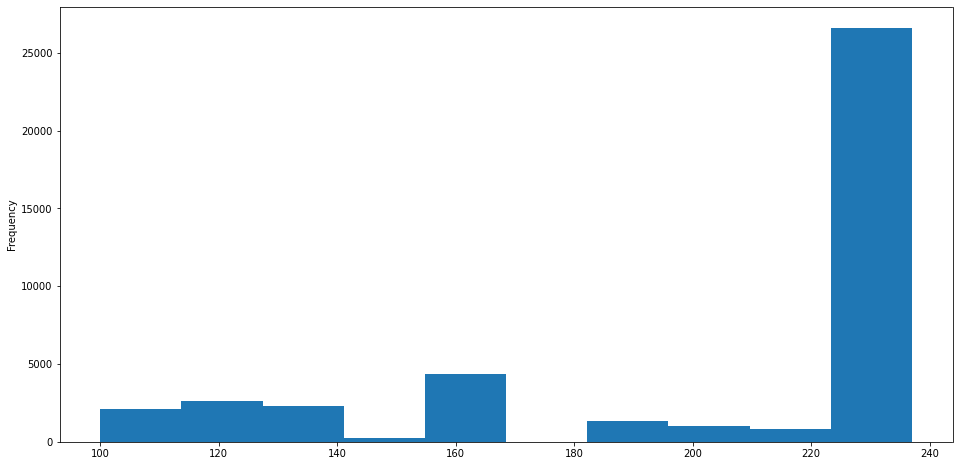

In [ ]:
xTrain_single['card5'].plot.hist(figsize=(16,8));

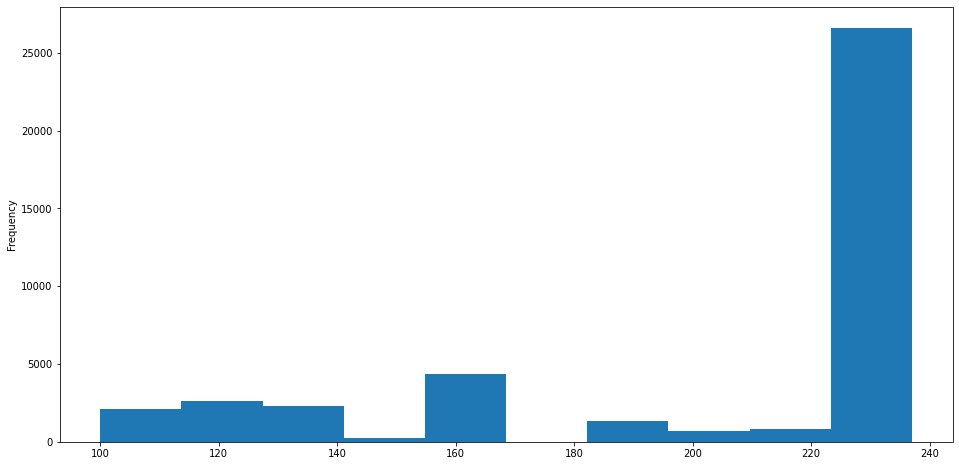

In [ ]:
xTrain_before_filling['card5'].plot.hist(figsize=(16,8));

Filling values isn't changing the existing variables much because of filling with measures like mean of the variable. It just models to not misunderstand missing values.

In [ ]:
print(xTrain_single['card5'].describe())
print(xTrain_before_filling['card5'].describe())

count    41337.000000
mean       199.235991
std         41.036349
min        100.000000
25%        166.000000
50%        226.000000
75%        226.000000
max        237.000000
Name: card5, dtype: float64
count    41027.000000
mean       199.235991
std         41.191096
min        100.000000
25%        166.000000
50%        226.000000
75%        226.000000
max        237.000000
Name: card5, dtype: float64


In [ ]:
xTrain = xTrain_single

Step 2. One hot encoding 

In [ ]:
xTrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41337 entries, 12662 to 52734
Columns: 181 entries, TransactionID to V321
dtypes: float64(160), int64(17), object(4)
memory usage: 58.4+ MB


In [ ]:
xTrain_dummy = pd.get_dummies(xTrain, prefix_sep='_', drop_first=True)
xTrain_dummy

,TransactionID,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,...,P_emaildomain_web.de,P_emaildomain_windstream.net,P_emaildomain_yahoo.co.jp,P_emaildomain_yahoo.co.uk,P_emaildomain_yahoo.com,P_emaildomain_yahoo.com.mx,P_emaildomain_yahoo.de,P_emaildomain_yahoo.es,P_emaildomain_yahoo.fr,P_emaildomain_ymail.com
12662,3058646,1612658,46.500,7861,494.0,150.0,226.0,299.000000,87.000000,1,...,0,0,0,0,0,0,0,0,0,0
47037,3469434,12533197,20.950,10748,455.0,150.0,195.0,337.000000,87.000000,9,...,0,0,0,0,0,0,0,0,0,0
29179,3302515,7855766,139.117,4606,141.0,185.0,137.0,290.763705,86.802851,1,...,0,0,0,0,0,0,0,0,0,0
40680,3010196,595984,280.330,4141,404.0,150.0,102.0,327.000000,87.000000,1,...,0,0,0,0,0,0,0,0,0,0
6080,3288879,7447462,186.610,13266,321.0,150.0,226.0,158.000000,87.000000,13,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54370,3500688,13452492,311.950,10057,225.0,150.0,224.0,123.000000,87.000000,3,...,0,0,0,0,0,0,0,0,0,0
17730,3038837,1212291,114.950,2492,543.0,150.0,224.0,299.000000,87.000000,3,...,0,0,0,0,0,0,0,0,0,0
28030,3055357,1544901,75.000,1690,516.0,150.0,224.0,110.000000,87.000000,1,...,0,0,0,0,0,0,0,0,0,0
15725,3144269,3273875,206.000,17188,321.0,150.0,226.0,310.000000,87.000000,6,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
final_tr = pd.DataFrame(data=xTrain_dummy)

print(final_tr.head())
print(final_tr.shape)

       TransactionID  TransactionDT  TransactionAmt  card1  card2  card3  \
12662        3058646        1612658          46.500   7861  494.0  150.0   
47037        3469434       12533197          20.950  10748  455.0  150.0   
29179        3302515        7855766         139.117   4606  141.0  185.0   
40680        3010196         595984         280.330   4141  404.0  150.0   
6080         3288879        7447462         186.610  13266  321.0  150.0   

       card5       addr1      addr2  C1  ...  P_emaildomain_web.de  \
12662  226.0  299.000000  87.000000   1  ...                     0   
47037  195.0  337.000000  87.000000   9  ...                     0   
29179  137.0  290.763705  86.802851   1  ...                     0   
40680  102.0  327.000000  87.000000   1  ...                     0   
6080   226.0  158.000000  87.000000  13  ...                     0   

       P_emaildomain_windstream.net  P_emaildomain_yahoo.co.jp  \
12662                             0                     

Decision Tree using grid search CV

In [ ]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV
parameters = {'max_depth':range(3,20)}
clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4,cv=5,scoring = 'roc_auc')
clf.fit(X=final_tr, y=yTrain)
dt = clf.best_estimator_ #final decision tree!
print(clf.best_score_, clf.best_params_)

0.7638879724288731 {'max_depth': 8}


Visualizing the decision tree

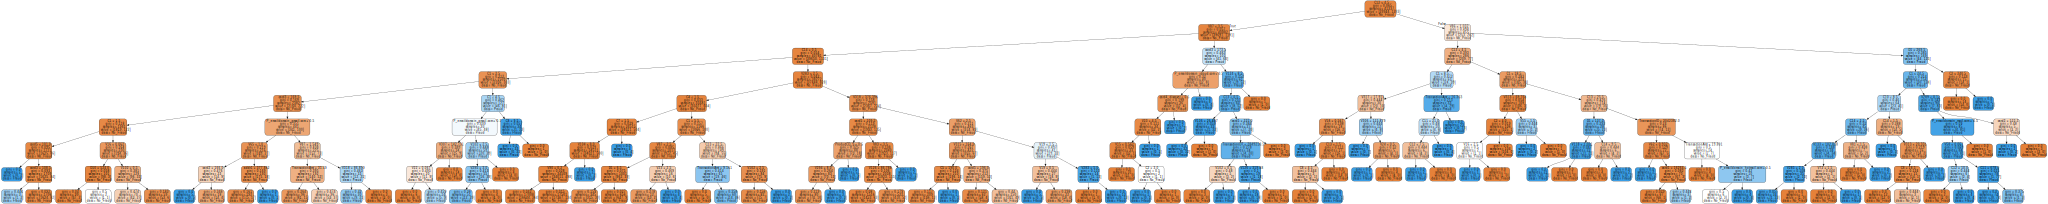

In [ ]:
## load visualization libraries
from sklearn.tree import export_graphviz
import graphviz
dot_data = tree.export_graphviz(dt, out_file=None, feature_names=final_tr.columns,
                class_names=['No_Fraud','Fraud'], filled=True, 
                rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
display(graph)

## Handling Class Imbalance

use SMOTE (Synthetic Minority Oversampling Technique) and resample data

In [ ]:
#Libraries and functions to load for class imbalance
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

over = SMOTE(sampling_strategy=0.2,random_state=2) #
# under = RandomUnderSampler(sampling_strategy=0.2) : 
# we are avoid under sampling of non fraud data, to avoid removing data: this worked well in this case!
steps = [('o', over)] # only do oversampling
pipeline = Pipeline(steps=steps)
X_res, y_res = pipeline.fit_resample(xTrain_dummy, yTrain)

print('Original dataset shape %s' % Counter(yTrain))
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({0: 39944, 1: 1393})
Resampled dataset shape Counter({0: 39944, 1: 7988})


we have number of fraud and non-fraud cases in the ratio 1:5 and are relatively balanced information for model to learn

Now use SMOTE data for training a decsision tree classification

In [ ]:
from sklearn import preprocessing
#scaled_tr_res = preprocessing.StandardScaler().fit_transform(X_res)
final_tr_res = pd.DataFrame(data=X_res)
final_tr_res.columns = xTrain_dummy.columns
final_tr_res.head()

,TransactionID,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,...,P_emaildomain_web.de,P_emaildomain_windstream.net,P_emaildomain_yahoo.co.jp,P_emaildomain_yahoo.co.uk,P_emaildomain_yahoo.com,P_emaildomain_yahoo.com.mx,P_emaildomain_yahoo.de,P_emaildomain_yahoo.es,P_emaildomain_yahoo.fr,P_emaildomain_ymail.com
0,3058646,1612658,46.500,7861,494.0,150.0,226.0,299.000000,87.000000,1,...,0,0,0,0,0,0,0,0,0,0
1,3469434,12533197,20.950,10748,455.0,150.0,195.0,337.000000,87.000000,9,...,0,0,0,0,0,0,0,0,0,0
2,3302515,7855766,139.117,4606,141.0,185.0,137.0,290.763705,86.802851,1,...,0,0,0,0,0,0,0,0,0,0
3,3010196,595984,280.330,4141,404.0,150.0,102.0,327.000000,87.000000,1,...,0,0,0,0,0,0,0,0,0,0
4,3288879,7447462,186.610,13266,321.0,150.0,226.0,158.000000,87.000000,13,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
## Decision Tree using grid search CV
from sklearn import tree
from sklearn.model_selection import GridSearchCV
parameters = {'max_depth':range(3,20)}
clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4,cv=5,scoring = 'roc_auc')
clf.fit(X=final_tr_res, y=y_res)
dt_smote = clf.best_estimator_ #final decision tree!
print(clf.best_score_, clf.best_params_)

0.9313983443604072 {'max_depth': 8}


An increased performance on resampled regarding best score 0.9313983443604072 vs. 0.7624612645965352

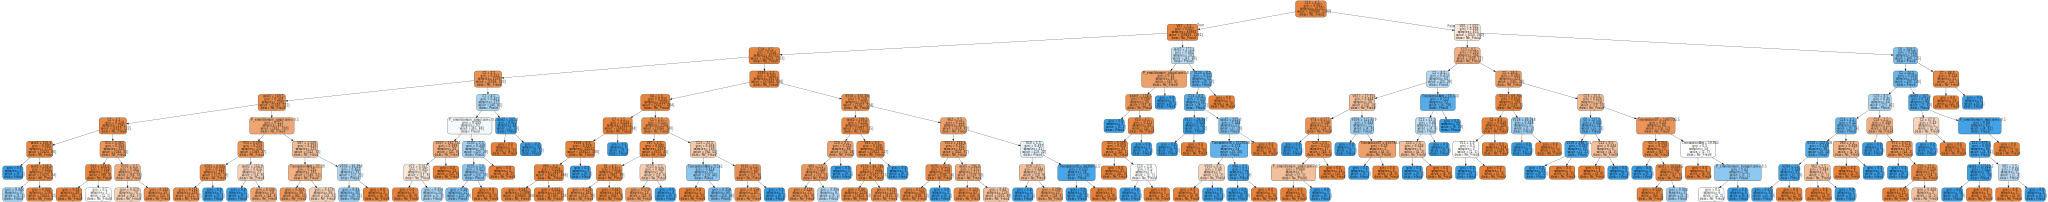

In [ ]:
## Visualizing the decision tree initially- load visualization libraries
from sklearn.tree import export_graphviz
import graphviz
dot_data = tree.export_graphviz(dt, out_file=None, feature_names=final_tr.columns, 
                class_names=['No_Fraud','Fraud'], filled=True, 
                rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph

### Apply on Test Data 

Step 1: Account for missing values with single imputation

In [ ]:
cols= xTest.columns
num_cols = xTest.select_dtypes(include=np.number).columns
xTest.loc[:,num_cols] = xTest.loc[:,num_cols].fillna(xTest.loc[:,num_cols].mean())

cat_cols= list(set(cols) - set(num_cols))
xTest.loc[:,cat_cols] = xTest.loc[:,cat_cols].fillna(xTest.loc[:,cat_cols].mode().iloc[0])
test_cols = xTest.columns

Step 2: Select only those features which are there in training

In [ ]:
xTest = xTest[train_cols]

Step 3. One Hot encode variables

In [ ]:
xTest.info()
# Dummify categorical vars
xTest_dummy = pd.get_dummies(xTest, prefix_sep='_', drop_first=True)

## missing columns levels train and test
missing_levels_cols = list(set(xTrain_dummy.columns) - set(xTest_dummy.columns))

for c in missing_levels_cols:
  xTest_dummy[c] = 0

# Select only those columns which are there in training data
xTest_dummy = xTest_dummy[xTrain_dummy.columns]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17717 entries, 59044 to 426
Columns: 181 entries, TransactionID to V321
dtypes: float64(160), int64(17), object(4)
memory usage: 24.6+ MB


Step 4: make sure test data again has exact same number of variables as training 

In [ ]:
from sklearn import preprocessing

final_ts = pd.DataFrame(data=xTest_dummy)
final_ts.columns = xTest_dummy.columns
final_ts
print(final_ts.head())
print(final_ts.shape)

       TransactionID  TransactionDT  TransactionAmt  card1      card2  card3  \
59044        3195138        4809520          36.950  17188  321.00000  150.0   
29992        3181635        4385698         612.950   2616  362.01623  150.0   
56452        3246331        6215794          49.000  12581  453.00000  150.0   
7059         3015519         716506         150.000  16659  170.00000  150.0   
49961        3353372        9094718         140.658   2256  545.00000  185.0   

       card5       addr1      addr2  C1  ...  P_emaildomain_web.de  \
59044  226.0  310.000000  87.000000   2  ...                     0   
29992  102.0  204.000000  87.000000   1  ...                     0   
56452  226.0  299.000000  87.000000   1  ...                     0   
7059   226.0  299.000000  87.000000  17  ...                     0   
49961  226.0  290.396535  86.815445   2  ...                     0   

       P_emaildomain_windstream.net  P_emaildomain_yahoo.co.jp  \
59044                           

Prediction on test data: Without SMOTE vs With SMOTE

In [ ]:
ytest_dt = dt.predict_proba(final_ts)

from sklearn.metrics import roc_curve,roc_auc_score
print('The ROC AUC score for 1st model without SMOTE is {}'.format(roc_auc_score(yTest,ytest_dt[:,1])))

The ROC AUC score for 1st model without SMOTE is 0.773173001052706


In [ ]:
ytest_dt_smote = dt_smote.predict_proba(final_ts)
print('The ROC AUC score for 1st model after SMOTE is {}'.format(roc_auc_score(yTest,ytest_dt_smote[:,1])))

The ROC AUC score for 1st model after SMOTE is 0.8178751292000771


There is increase performance of decision tree classifer after SMOTE is applied, with respect to AUC.

Scaling/Normalizing Data

In [ ]:
from sklearn import preprocessing
scaled_tr = preprocessing.StandardScaler().fit_transform(xTrain_dummy)
final_tr = pd.DataFrame(data=scaled_tr)
final_tr.columns = xTrain_dummy.columns
final_tr
print(final_tr.head())
print(final_tr.shape)

   TransactionID  TransactionDT  TransactionAmt     card1     card2     card3  \
0      -1.312209      -1.247296       -0.374456 -0.418551  0.842286 -0.284774   
1       1.103287       1.123641       -0.482904  0.170473  0.592257 -0.284774   
2       0.121778       0.108133        0.018660 -1.082656 -1.420799  2.807597   
3      -1.597102      -1.468024        0.618044 -1.177529  0.265295 -0.284774   
4       0.041596       0.019487        0.220246  0.684211 -0.266818 -0.284774   

      card5     addr1         addr2        C1  ...  P_emaildomain_web.de  \
0  0.652210  0.085823  7.759246e-02 -0.099786  ...             -0.020872   
1 -0.103227  0.481788  7.759246e-02 -0.033725  ...             -0.020872   
2 -1.516625  0.000000 -5.593017e-15 -0.099786  ...             -0.020872   
3 -2.369537  0.377587  7.759246e-02 -0.099786  ...             -0.020872   
4  0.652210 -1.383415  7.759246e-02 -0.000694  ...             -0.020872   

   P_emaildomain_windstream.net  P_emaildomain_yahoo.co.